In [5]:
# !pip install oolearning --upgrade

In [7]:
import copy
import os
import oolearning as oo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from helpers import column_log, BinaryAucRocScore

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [8]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [9]:
def create_net_capital(x):
    temp = x.copy()
    temp['net capital'] = temp['capital-gain'] - temp['capital-loss']
    return temp

In [10]:
global_transformations = [
                         oo.ImputationTransformer(),
                         oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                       custom_function=column_log),
                         oo.StatelessTransformer(custom_function=create_net_capital),
                         oo.CenterScaleTransformer(),
                         oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

In [6]:
params_dict = dict(    
#     n_estimators=[3750],
#     max_features=[0.985, 0.99, 0.995, 1.0],
#     max_depth=[13, 14, 15],
#    min_samples_split=[0.001, 0.002, 0.005],
#    min_samples_leaf=[0.001, 0.002, 0.005],
    min_weight_fraction_leaf=[0, 0.1, 0.5, 2, 10]
)
grid = oo.HyperParamsGrid(params_dict=params_dict)
grid.params_grid

,min_weight_fraction_leaf
0,0.0
1,0.1
2,0.5
3,2.0
4,10.0


In [7]:
hyper_param_object = oo.RandomForestHP(
    criterion='gini',
    num_features=None,
    max_features=1.0,  # tuned
    n_estimators=3750,  # tuned
    max_depth=14,  # tuned
   # min_samples_split=16,
   # min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0,
    )

In [8]:
model=oo.RandomForestClassifier(extra_trees_implementation=True)

In [9]:
repeats = 5
folds = 5

In [10]:
model_cache_directory = 'tuner_ExtraTrees'
resampler_cache_directory = 'tuner_ExtraTrees_resample_cache'

In [14]:
score_list = [oo.AucRocScore(positive_class=positive_class),
              oo.FBetaScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                    positive_class=positive_class),
                            beta=0.5),
              oo.SensitivityScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                          positive_class=positive_class)),
              oo.PositivePredictiveValueScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                                      positive_class=positive_class))]

In [12]:

# define/configure the resampler
resampler = oo.RepeatedCrossValidationResampler(model=model,  # using a Random Forest model
                                             transformations=global_transformations,
                                             scores=[s.clone() for s in score_list],
                                             folds=folds,
                                             repeats=repeats)
# define/configure the ModelTuner
tuner = oo.ModelTuner(resampler=resampler,
                      hyper_param_object=hyper_param_object,
                      #model_persistence_manager=oo.LocalCacheManager(cache_directory=model_cache_directory),
                      resampler_persistence_manager=oo.LocalCacheManager(cache_directory=resampler_cache_directory),
                      #parallelization_cores=-1,
                      parallelization_cores=0,
                     )

In [13]:
tuner.tune(data_x=explore.dataset.drop(columns=target_variable),
           data_y=explore.dataset[target_variable],
           params_grid=grid)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x107293a50, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/shanekercheval/anaconda3/lib/python3.6/si...ges/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/shane.../python3.6/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x107293a50, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/shanekercheval/anaconda3/lib/python3.6/si...ges/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/shane.../python3.6/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle IOLoop._run_callback(functools.par... 0x11001e158>))>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle IOLoop._run_callback(functools.par... 0x11001e158>))>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method IOLoop._run_callback of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (functools.partial(<function wrap.<locals>.null_wrapper at 0x11001e158>),)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in _run_callback(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, callback=functools.partial(<function wrap.<locals>.null_wrapper at 0x11001e158>))
    754         """Runs a callback with error handling.
    755 
    756         For use in subclasses.
    757         """
    758         try:
--> 759             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_wrapper at 0x11001e158>)
    760             if ret is not None:
    761                 from tornado import gen
    762                 # Functions that return Futures typically swallow all
    763                 # exceptions and store them in the Future.  If a Future

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ()
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in <lambda>()
    531             return
    532 
    533         if state & self.socket.events:
    534             # events still exist that haven't been processed
    535             # explicitly schedule handling to avoid missing events due to edge-triggered FDs
--> 536             self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
    537 
    538     def _init_io_state(self):
    539         """initialize the ioloop event handler"""
    540         with stack_context.NullContext():

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=0)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'tuner.tune(data_x=explore.dataset.drop(columns=t...et[target_variable],\n           params_grid=grid)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 7, 21, 16, 45, 20, 65161, tzinfo=tzutc()), 'msg_id': '32c503ebf04948869e3964c861f0c8d8', 'msg_type': 'execute_request', 'session': '180f873bfa994a06a1fe87cb1ec4ad33', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '32c503ebf04948869e3964c861f0c8d8', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'180f873bfa994a06a1fe87cb1ec4ad33']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'tuner.tune(data_x=explore.dataset.drop(columns=t...et[target_variable],\n           params_grid=grid)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 7, 21, 16, 45, 20, 65161, tzinfo=tzutc()), 'msg_id': '32c503ebf04948869e3964c861f0c8d8', 'msg_type': 'execute_request', 'session': '180f873bfa994a06a1fe87cb1ec4ad33', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '32c503ebf04948869e3964c861f0c8d8', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'180f873bfa994a06a1fe87cb1ec4ad33'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'tuner.tune(data_x=explore.dataset.drop(columns=t...et[target_variable],\n           params_grid=grid)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 7, 21, 16, 45, 20, 65161, tzinfo=tzutc()), 'msg_id': '32c503ebf04948869e3964c861f0c8d8', 'msg_type': 'execute_request', 'session': '180f873bfa994a06a1fe87cb1ec4ad33', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '32c503ebf04948869e3964c861f0c8d8', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='tuner.tune(data_x=explore.dataset.drop(columns=t...et[target_variable],\n           params_grid=grid)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'tuner.tune(data_x=explore.dataset.drop(columns=t...et[target_variable],\n           params_grid=grid)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('tuner.tune(data_x=explore.dataset.drop(columns=t...et[target_variable],\n           params_grid=grid)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('tuner.tune(data_x=explore.dataset.drop(columns=t...et[target_variable],\n           params_grid=grid)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='tuner.tune(data_x=explore.dataset.drop(columns=t...et[target_variable],\n           params_grid=grid)', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'tuner.tune(data_x=explore.dataset.drop(columns=t...et[target_variable],\n           params_grid=grid)'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='tuner.tune(data_x=explore.dataset.drop(columns=t...et[target_variable],\n           params_grid=grid)', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-13-fb8917063347>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 10fee8a58, execution_...rue silent=False shell_futures=True> result=None>)
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])
   2908                 code = compiler(mod, cell_name, "single")
-> 2909                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x10ffa39c0, file "<ipython-input-13-fb8917063347>", line 1>
        result = <ExecutionResult object at 10fee8a58, execution_...rue silent=False shell_futures=True> result=None>
   2910                     return True
   2911 
   2912             # Flush softspace
   2913             if softspace(sys.stdout, 0):

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x10ffa39c0, file "<ipython-input-13-fb8917063347>", line 1>, result=<ExecutionResult object at 10fee8a58, execution_...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x10ffa39c0, file "<ipython-input-13-fb8917063347>", line 1>
        self.user_global_ns = {'BinaryAucRocScore': <class 'helpers.BinaryAucRocScore'>, 'In': ['', '# !pip install oolearning --upgrade', "import copy\nimport os\nimport oolearning as oo\nim...rcParams['figure.figsize'] = [width, width/1.333]", "csv_file = '../census.csv'\ntarget_variable = 'in...positive_class = '>50K'\n\nexplore.dataset.head(20)", "def create_net_capital(x):\n    temp = x.copy()\n ...tal-gain'] - temp['capital-loss']\n    return temp", 'global_transformations = [\n                     ...codeTransformer(oo.CategoricalEncoding.ONE_HOT)\n]', 'params_dict = dict(    \n#     n_estimators=[3750...amsGrid(params_dict=params_dict)\ngrid.params_grid', 'hyper_param_object = oo.RandomForestHP(\n    crit...af_nodes=None,\n    min_impurity_decrease=0,\n    )', 'model=oo.RandomForestClassifier(extra_trees_implementation=True)', 'repeats = 5\nfolds = 5', "model_cache_directory = 'tuner_ExtraTrees'\nresam...che_directory = 'tuner_ExtraTrees_resample_cache'", 'score_list = [oo.AucRocScore(positive_class=posi...                 positive_class=positive_class))]', '\n# define/configure the resampler\nresampler = oo...  parallelization_cores=0,\n                     )', 'tuner.tune(data_x=explore.dataset.drop(columns=t...et[target_variable],\n           params_grid=grid)'], 'Out': {3:     age         workclass education_level  educa....0           60.0            United-States  >50K , 6:    min_weight_fraction_leaf
0  0.0              ...                     
4  10.0                    }, '_':    min_weight_fraction_leaf
0  0.0              ...                     
4  10.0                    , '_3':     age         workclass education_level  educa....0           60.0            United-States  >50K , '_6':    min_weight_fraction_leaf
0  0.0              ...                     
4  10.0                    , '__':     age         workclass education_level  educa....0           60.0            United-States  >50K , '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, ...}
        self.user_ns = {'BinaryAucRocScore': <class 'helpers.BinaryAucRocScore'>, 'In': ['', '# !pip install oolearning --upgrade', "import copy\nimport os\nimport oolearning as oo\nim...rcParams['figure.figsize'] = [width, width/1.333]", "csv_file = '../census.csv'\ntarget_variable = 'in...positive_class = '>50K'\n\nexplore.dataset.head(20)", "def create_net_capital(x):\n    temp = x.copy()\n ...tal-gain'] - temp['capital-loss']\n    return temp", 'global_transformations = [\n                     ...codeTransformer(oo.CategoricalEncoding.ONE_HOT)\n]', 'params_dict = dict(    \n#     n_estimators=[3750...amsGrid(params_dict=params_dict)\ngrid.params_grid', 'hyper_param_object = oo.RandomForestHP(\n    crit...af_nodes=None,\n    min_impurity_decrease=0,\n    )', 'model=oo.RandomForestClassifier(extra_trees_implementation=True)', 'repeats = 5\nfolds = 5', "model_cache_directory = 'tuner_ExtraTrees'\nresam...che_directory = 'tuner_ExtraTrees_resample_cache'", 'score_list = [oo.AucRocScore(positive_class=posi...                 positive_class=positive_class))]', '\n# define/configure the resampler\nresampler = oo...  parallelization_cores=0,\n                     )', 'tuner.tune(data_x=explore.dataset.drop(columns=t...et[target_variable],\n           params_grid=grid)'], 'Out': {3:     age         workclass education_level  educa....0           60.0            United-States  >50K , 6:    min_weight_fraction_leaf
0  0.0              ...                     
4  10.0                    }, '_':    min_weight_fraction_leaf
0  0.0              ...                     
4  10.0                    , '_3':     age         workclass education_level  educa....0           60.0            United-States  >50K , '_6':    min_weight_fraction_leaf
0  0.0              ...                     
4  10.0                    , '__':     age         workclass education_level  educa....0           60.0            United-States  >50K , '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/Users/shanekercheval/personal_repos/udacity/data_scientist_nanodegree/projects/p1_charityml/custom/<ipython-input-13-fb8917063347> in <module>()
      1 tuner.tune(data_x=explore.dataset.drop(columns=target_variable),
      2            data_y=explore.dataset[target_variable],
----> 3            params_grid=grid)

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/model_processors/ModelTuner.py in tune(self=<oolearning.model_processors.ModelTuner.ModelTuner object>, data_x=       age         workclass education_level  ed...       60.0            United-States             , data_y=0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, params_grid=<oolearning.model_wrappers.HyperParamsGrid.HyperParamsGrid object>)
    172                                  data_y=data_y)  # decorators
    173                             for x in range(len(params_combinations))]
    174 
    175         start_time = time.time()
    176         if self._parallelization_cores == 0 or self._parallelization_cores == 1:
--> 177             results = list(map(single_tune, single_tune_args))
        results = undefined
        single_tune_args = [{'data_x':        age         workclass education_level  ed...       60.0            United-States             , 'data_y': 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, 'decorators': None, 'has_params': True, 'hyper_param_object': <oolearning.model_wrappers.RandomForest.RandomForestHP object>, 'model_persistence_manager': None, 'params_combo_index': {'min_weight_fraction_leaf': 0.0}, 'resampler_copy': <oolearning.model_processors.RepeatedCrossValida...esampler.RepeatedCrossValidationResampler object>, 'resampler_persistence_manager': <oolearning.persistence.LocalCacheManager.LocalCacheManager object>}, {'data_x':        age         workclass education_level  ed...       60.0            United-States             , 'data_y': 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, 'decorators': None, 'has_params': True, 'hyper_param_object': <oolearning.model_wrappers.RandomForest.RandomForestHP object>, 'model_persistence_manager': None, 'params_combo_index': {'min_weight_fraction_leaf': 0.1}, 'resampler_copy': <oolearning.model_processors.RepeatedCrossValida...esampler.RepeatedCrossValidationResampler object>, 'resampler_persistence_manager': <oolearning.persistence.LocalCacheManager.LocalCacheManager object>}, {'data_x':        age         workclass education_level  ed...       60.0            United-States             , 'data_y': 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, 'decorators': None, 'has_params': True, 'hyper_param_object': <oolearning.model_wrappers.RandomForest.RandomForestHP object>, 'model_persistence_manager': None, 'params_combo_index': {'min_weight_fraction_leaf': 0.5}, 'resampler_copy': <oolearning.model_processors.RepeatedCrossValida...esampler.RepeatedCrossValidationResampler object>, 'resampler_persistence_manager': <oolearning.persistence.LocalCacheManager.LocalCacheManager object>}, {'data_x':        age         workclass education_level  ed...       60.0            United-States             , 'data_y': 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, 'decorators': None, 'has_params': True, 'hyper_param_object': <oolearning.model_wrappers.RandomForest.RandomForestHP object>, 'model_persistence_manager': None, 'params_combo_index': {'min_weight_fraction_leaf': 2.0}, 'resampler_copy': <oolearning.model_processors.RepeatedCrossValida...esampler.RepeatedCrossValidationResampler object>, 'resampler_persistence_manager': <oolearning.persistence.LocalCacheManager.LocalCacheManager object>}, {'data_x':        age         workclass education_level  ed...       60.0            United-States             , 'data_y': 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, 'decorators': None, 'has_params': True, 'hyper_param_object': <oolearning.model_wrappers.RandomForest.RandomForestHP object>, 'model_persistence_manager': None, 'params_combo_index': {'min_weight_fraction_leaf': 10.0}, 'resampler_copy': <oolearning.model_processors.RepeatedCrossValida...esampler.RepeatedCrossValidationResampler object>, 'resampler_persistence_manager': <oolearning.persistence.LocalCacheManager.LocalCacheManager object>}]
    178         else:
    179             cores = cpu_count() if self._parallelization_cores == -1 else self._parallelization_cores
    180             with ThreadPool(cores) as pool:
    181                 results = list(pool.map(single_tune, single_tune_args))

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/model_processors/ModelTuner.py in single_tune(args={'data_x':        age         workclass education_level  ed...       60.0            United-States             , 'data_y': 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, 'decorators': None, 'has_params': True, 'hyper_param_object': <oolearning.model_wrappers.RandomForest.RandomForestHP object>, 'model_persistence_manager': None, 'params_combo_index': {'min_weight_fraction_leaf': 2.0}, 'resampler_copy': <oolearning.model_processors.RepeatedCrossValida...esampler.RepeatedCrossValidationResampler object>, 'resampler_persistence_manager': <oolearning.persistence.LocalCacheManager.LocalCacheManager object>})
     63                                                       hyper_params=hyper_param_object)
     64         resampler_persistence_manager.set_key(key=cache_key)
     65         resampler_copy.set_results_persistence_manager(persistence_manager=resampler_persistence_manager.clone())  # noqa
     66 
     67     start_time_individual = time.time()
---> 68     resampler_copy.resample(data_x=data_x, data_y=data_y, hyper_params=hyper_param_object)
        resampler_copy.resample = <bound method ResamplerBase.resample of <oolearn...sampler.RepeatedCrossValidationResampler object>>
        data_x =        age         workclass education_level  ed...       60.0            United-States             
        data_y = 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object
        hyper_param_object = <oolearning.model_wrappers.RandomForest.RandomForestHP object>
     69     execution_time_individual = "{0} seconds".format(round(time.time() - start_time_individual))
     70     # print(execution_time)
     71     return resampler_copy.results, execution_time_individual
     72 

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/model_processors/ResamplerBase.py in resample(self=<oolearning.model_processors.RepeatedCrossValida...esampler.RepeatedCrossValidationResampler object>, data_x=       age         workclass education_level  ed...       60.0            United-States             , data_y=0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, hyper_params=<oolearning.model_wrappers.RandomForest.RandomForestHP object>)
    106         """
    107         # if we have a persistence manager, grab the cached resampling results if they exist (and skip
    108         # the resampling)
    109         if self._results_persistence_manager:
    110             self._results = self._results_persistence_manager. \
--> 111                 get_object(fetch_function=lambda: self._resample(data_x=data_x,
        self._resample = <bound method RepeatedCrossValidationResampler._...sampler.RepeatedCrossValidationResampler object>>
        data_x =        age         workclass education_level  ed...       60.0            United-States             
        data_y = 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object
        hyper_params = <oolearning.model_wrappers.RandomForest.RandomForestHP object>
    112                                                                  data_y=data_y,
    113                                                                  hyper_params=hyper_params))
    114         else:
    115             self._results = self._resample(data_x=data_x, data_y=data_y, hyper_params=hyper_params)

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/persistence/LocalCacheManager.py in get_object(self=<oolearning.persistence.LocalCacheManager.LocalCacheManager object>, fetch_function=<function ResamplerBase.resample.<locals>.<lambda>>, key=None)
     74         if os.path.isfile(self._cache_path):
     75             with open(self._cache_path, 'rb') as saved_object:
     76                 return pickle.load(saved_object)
     77         else:
     78             # fetch
---> 79             fetched_object = fetch_function()
        fetched_object = undefined
        fetch_function = <function ResamplerBase.resample.<locals>.<lambda>>
     80             assert fetched_object is not None
     81             # save; note, either the directory exists, or it doesn't exist but it is ok to create it
     82             # (otherwise we would have raised a NotADirectoryError in the constructor)
     83             os.makedirs(os.path.dirname(self._cache_path), exist_ok=True)

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/model_processors/ResamplerBase.py in <lambda>()
    108         # the resampling)
    109         if self._results_persistence_manager:
    110             self._results = self._results_persistence_manager. \
    111                 get_object(fetch_function=lambda: self._resample(data_x=data_x,
    112                                                                  data_y=data_y,
--> 113                                                                  hyper_params=hyper_params))
    114         else:
    115             self._results = self._resample(data_x=data_x, data_y=data_y, hyper_params=hyper_params)
    116 
    117         assert self._results is not None

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/model_processors/RepeatedCrossValidationResampler.py in _resample(self=<oolearning.model_processors.RepeatedCrossValida...esampler.RepeatedCrossValidationResampler object>, data_x=       age         workclass education_level  ed...       60.0            United-States             , data_y=0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, hyper_params=<oolearning.model_wrappers.RandomForest.RandomForestHP object>)
    242                               scores=self._scores,  # need to reuse this object type for each fold/repeat
    243                               decorators=self._decorators)
    244                          for x in range(self._repeats)]
    245 
    246         if self._parallelization_cores == 0 or self._parallelization_cores == 1:
--> 247             results = list(map(resample_repeat, resample_args))
        results = undefined
        resample_args = [{'data_x':        age         workclass education_level  ed...       60.0            United-States             , 'data_y': 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, 'decorators': None, 'folds': 5, 'hyper_params': <oolearning.model_wrappers.RandomForest.RandomForestHP object>, 'model': <oolearning.model_wrappers.RandomForest.RandomForestClassifier object>, 'persistence_manager': None, 'repeat_index': 0, 'scores': [<oolearning.evaluators.AucRocScore.AucRocScore object>, <oolearning.evaluators.FBetaScore.FBetaScore object>, <oolearning.evaluators.SensitivityScore.SensitivityScore object>, <oolearning.evaluators.PositivePredictiveValueScore.PositivePredictiveValueScore object>], 'train_callback': None, ...}, {'data_x':        age         workclass education_level  ed...       60.0            United-States             , 'data_y': 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, 'decorators': None, 'folds': 5, 'hyper_params': <oolearning.model_wrappers.RandomForest.RandomForestHP object>, 'model': <oolearning.model_wrappers.RandomForest.RandomForestClassifier object>, 'persistence_manager': None, 'repeat_index': 1, 'scores': [<oolearning.evaluators.AucRocScore.AucRocScore object>, <oolearning.evaluators.FBetaScore.FBetaScore object>, <oolearning.evaluators.SensitivityScore.SensitivityScore object>, <oolearning.evaluators.PositivePredictiveValueScore.PositivePredictiveValueScore object>], 'train_callback': None, ...}, {'data_x':        age         workclass education_level  ed...       60.0            United-States             , 'data_y': 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, 'decorators': None, 'folds': 5, 'hyper_params': <oolearning.model_wrappers.RandomForest.RandomForestHP object>, 'model': <oolearning.model_wrappers.RandomForest.RandomForestClassifier object>, 'persistence_manager': None, 'repeat_index': 2, 'scores': [<oolearning.evaluators.AucRocScore.AucRocScore object>, <oolearning.evaluators.FBetaScore.FBetaScore object>, <oolearning.evaluators.SensitivityScore.SensitivityScore object>, <oolearning.evaluators.PositivePredictiveValueScore.PositivePredictiveValueScore object>], 'train_callback': None, ...}, {'data_x':        age         workclass education_level  ed...       60.0            United-States             , 'data_y': 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, 'decorators': None, 'folds': 5, 'hyper_params': <oolearning.model_wrappers.RandomForest.RandomForestHP object>, 'model': <oolearning.model_wrappers.RandomForest.RandomForestClassifier object>, 'persistence_manager': None, 'repeat_index': 3, 'scores': [<oolearning.evaluators.AucRocScore.AucRocScore object>, <oolearning.evaluators.FBetaScore.FBetaScore object>, <oolearning.evaluators.SensitivityScore.SensitivityScore object>, <oolearning.evaluators.PositivePredictiveValueScore.PositivePredictiveValueScore object>], 'train_callback': None, ...}, {'data_x':        age         workclass education_level  ed...       60.0            United-States             , 'data_y': 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, 'decorators': None, 'folds': 5, 'hyper_params': <oolearning.model_wrappers.RandomForest.RandomForestHP object>, 'model': <oolearning.model_wrappers.RandomForest.RandomForestClassifier object>, 'persistence_manager': None, 'repeat_index': 4, 'scores': [<oolearning.evaluators.AucRocScore.AucRocScore object>, <oolearning.evaluators.FBetaScore.FBetaScore object>, <oolearning.evaluators.SensitivityScore.SensitivityScore object>, <oolearning.evaluators.PositivePredictiveValueScore.PositivePredictiveValueScore object>], 'train_callback': None, ...}]
    248         else:
    249             cores = cpu_count() if self._parallelization_cores == -1 else self._parallelization_cores
    250             with ThreadPool(cores) as pool:
    251                 results = list(pool.map(resample_repeat, resample_args))

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/model_processors/RepeatedCrossValidationResampler.py in resample_repeat(args={'data_x':        age         workclass education_level  ed...       60.0            United-States             , 'data_y': 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object, 'decorators': None, 'folds': 5, 'hyper_params': <oolearning.model_wrappers.RandomForest.RandomForestHP object>, 'model': <oolearning.model_wrappers.RandomForest.RandomForestClassifier object>, 'persistence_manager': None, 'repeat_index': 0, 'scores': [<oolearning.evaluators.AucRocScore.AucRocScore object>, <oolearning.evaluators.FBetaScore.FBetaScore object>, <oolearning.evaluators.SensitivityScore.SensitivityScore object>, <oolearning.evaluators.PositivePredictiveValueScore.PositivePredictiveValueScore object>], 'train_callback': None, ...})
    118                                               repeat_index=repeat_index,
    119                                               fold_index=fold_index)
    120             persistence_manager.set_key(key=cache_key)
    121             model_copy.set_persistence_manager(persistence_manager=persistence_manager)
    122 
--> 123         model_copy.train(data_x=train_x_transformed, data_y=train_y, hyper_params=hyper_params)
        model_copy.train = <bound method ModelWrapperBase.train of <oolearn...pers.RandomForest.RandomForestClassifier object>>
        data_x =        age         workclass education_level  ed...       60.0            United-States             
        train_x_transformed =             age  education-num  capital-gain  ca...                      0                          
        data_y = 0        <=50K
1        <=50K
2        <=50K
3  ... <=50K
45221    >50K 
Name: income, dtype: object
        train_y = 0        <=50K
2        <=50K
3        <=50K
4  ... <=50K
45221    >50K 
Name: income, dtype: object
        hyper_params = <oolearning.model_wrappers.RandomForest.RandomForestHP object>
    124         predicted_values = model_copy.predict(data_x=holdout_x_transformed)
    125 
    126         fold_scores = list()
    127         for score in scores:  # cycle through scores and store results of each fold

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/model_wrappers/ModelWrapperBase.py in train(self=<oolearning.model_wrappers.RandomForest.RandomForestClassifier object>, data_x=            age  education-num  capital-gain  ca...                      0                          , data_y=0        <=50K
2        <=50K
3        <=50K
4  ... <=50K
45221    >50K 
Name: income, dtype: object, hyper_params=<oolearning.model_wrappers.RandomForest.RandomForestHP object>)
    113             self._model_object = self._persistence_manager.\
    114                 get_object(fetch_function=lambda: self._train(data_x=data_x,
    115                                                               data_y=data_y,
    116                                                               hyper_params=hyper_params))
    117         else:
--> 118             self._model_object = self._train(data_x=data_x, data_y=data_y, hyper_params=hyper_params)
        self._model_object = None
        self._train = <bound method RandomForestClassifier._train of <...pers.RandomForest.RandomForestClassifier object>>
        data_x =             age  education-num  capital-gain  ca...                      0                          
        data_y = 0        <=50K
2        <=50K
3        <=50K
4  ... <=50K
45221    >50K 
Name: income, dtype: object
        hyper_params = <oolearning.model_wrappers.RandomForest.RandomForestHP object>
    119 
    120         assert self._model_object is not None
    121 
    122     def predict(self, data_x: pd.DataFrame) -> Union[np.ndarray, pd.DataFrame]:

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/model_wrappers/RandomForest.py in _train(self=<oolearning.model_wrappers.RandomForest.RandomForestClassifier object>, data_x=            age  education-num  capital-gain  ca...                      0                          , data_y=0        <=50K
2        <=50K
3        <=50K
4  ... <=50K
45221    >50K 
Name: income, dtype: object, hyper_params=<oolearning.model_wrappers.RandomForest.RandomForestHP object>)
    165                 bootstrap=param_dict['bootstrap'],
    166                 oob_score=param_dict['oob_score'],
    167                 n_jobs=self._num_jobs_in_parallel,
    168                 random_state=self._seed,
    169             )
--> 170         model.fit(data_x, data_y)
        model.fit = <bound method BaseForest.fit of ExtraTreesClassi...e, random_state=42, verbose=0, warm_start=False)>
        data_x =             age  education-num  capital-gain  ca...                      0                          
        data_y = 0        <=50K
2        <=50K
3        <=50K
4  ... <=50K
45221    >50K 
Name: income, dtype: object
    171         return model
    172 
    173 
    174 class RandomForestRegressor(SklearnPredictArrayMixin, ModelWrapperBase):

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py in fit(self=ExtraTreesClassifier(bootstrap=True, class_weigh...se, random_state=42, verbose=0, warm_start=False), X=array([[ 0.03349902,  1.1263381 ,  2.8201218 , ....        0.        ,  0.        ]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 3749
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Jul 21 10:08:25 2018
PID: 48044         Python 3.6.5: /Users/shanekercheval/anaconda3/bin/python
...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (ExtraTreeClassifier(class_weight=None, criterion...om_state=1608637542,
          splitter='random'), ExtraTreesClassifier(bootstrap=True, class_weigh...se, random_state=42, verbose=0, warm_start=False), array([[ 0.03349902,  1.1263381 ,  2.8201218 , ....        0.        ,  0.        ]], dtype=float32), array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]]), None, 0, 3750), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (ExtraTreeClassifier(class_weight=None, criterion...om_state=1608637542,
          splitter='random'), ExtraTreesClassifier(bootstrap=True, class_weigh...se, random_state=42, verbose=0, warm_start=False), array([[ 0.03349902,  1.1263381 ,  2.8201218 , ....        0.        ,  0.        ]], dtype=float32), array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]]), None, 0, 3750)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py in _parallel_build_trees(tree=ExtraTreeClassifier(class_weight=None, criterion...om_state=1608637542,
          splitter='random'), forest=ExtraTreesClassifier(bootstrap=True, class_weigh...se, random_state=42, verbose=0, warm_start=False), X=array([[ 0.03349902,  1.1263381 ,  2.8201218 , ....        0.        ,  0.        ]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]]), sample_weight=None, tree_idx=0, n_trees=3750, verbose=0, class_weight=None)
    116                 warnings.simplefilter('ignore', DeprecationWarning)
    117                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
--> 121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeClassifier.fit of Extr...m_state=1608637542,
          splitter='random')>
        X = array([[ 0.03349902,  1.1263381 ,  2.8201218 , ....        0.        ,  0.        ]], dtype=float32)
        y = array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])
        sample_weight = None
        curr_sample_weight = array([0., 2., 3., ..., 0., 0., 1.])
    122     else:
    123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    124 
    125     return tree

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=ExtraTreeClassifier(class_weight=None, criterion...om_state=1608637542,
          splitter='random'), X=array([[ 0.03349902,  1.1263381 ,  2.8201218 , ....        0.        ,  0.        ]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]]), sample_weight=array([0., 2., 3., ..., 0., 0., 1.]), check_input=False, X_idx_sorted=None)
    785 
    786         super(DecisionTreeClassifier, self).fit(
    787             X, y,
    788             sample_weight=sample_weight,
    789             check_input=check_input,
--> 790             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
    791         return self
    792 
    793     def predict_proba(self, X, check_input=True):
    794         """Predict class probabilities of the input samples X.

...........................................................................
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=ExtraTreeClassifier(class_weight=None, criterion...om_state=1608637542,
          splitter='random'), X=array([[ 0.03349902,  1.1263381 ,  2.8201218 , ....        0.        ,  0.        ]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]]), sample_weight=array([0., 2., 3., ..., 0., 0., 1.]), check_input=False, X_idx_sorted=None)
    233 
    234         if len(y) != n_samples:
    235             raise ValueError("Number of labels=%d does not match "
    236                              "number of samples=%d" % (len(y), n_samples))
    237         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
--> 238             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    239         if max_depth <= 0:
    240             raise ValueError("max_depth must be greater than zero. ")
    241         if not (0 < max_features <= self.n_features_):
    242             raise ValueError("max_features must be in (0, n_features]")

ValueError: min_weight_fraction_leaf must in [0, 0.5]
___________________________________________________________________________

In [ ]:
params_dict

In [ ]:
tuner.results.best_hyper_params

In [ ]:
tuner.results.best_model_resampler_object.score_means

In [ ]:
tuner.results.plot_resampled_stats()

In [ ]:
tuner.results.plot_resampled_scores(metric=oo.Metric.AUC_ROC,
                                    x_axis_limits=(0.90, 0.92),
                                    show_one_ste_rule=True
                                   )

In [ ]:
tuner.results.plot_resampled_scores(oo.Metric.FBETA_SCORE,
                                    x_axis_limits=(0.71, 0.75),
                                    show_one_ste_rule=True
                                   )

In [ ]:
params_dict

In [ ]:
tuner.results.best_hyper_params

In [ ]:
tuner.results.plot_hyper_params_profile(metric=oo.Metric.AUC_ROC,
                                        x_axis='max_features',
                                        line='max_depth',
#                                        grid='n_estimators'
                                       )

In [ ]:
tuner.results.plot_hyper_params_profile(metric=oo.Metric.AUC_ROC,
                                        x_axis='max_depth',
                                        line='max_features',
                                        grid='n_estimators'
                                       )

In [ ]:
tuner.results.plot_hyper_params_profile(metric=oo.Metric.AUC_ROC,
                                        x_axis='max_features',
                                        line='n_estimators',
                                       )

In [ ]:
tuner.results.plot_hyper_params_profile(metric=oo.Metric.AUC_ROC,
                                        x_axis='max_depth',
                                        line='n_estimators',
                                       )

In [ ]:
assert False

# Retrain on Full Training

In [12]:
final_hyper_param_object = oo.RandomForestHP(
    criterion='gini',
    num_features=None,
    max_features=1.0,  # tuned
    n_estimators=3750,  # tuned
    max_depth=14,  # tuned
    # min_samples_split=16,
    # min_samples_leaf=2,
    # min_weight_fraction_leaf=0.0,
    # max_leaf_nodes=None,
    # min_impurity_decrease=0,
)

final_model = oo.RandomForestClassifier()
final_transformations = [
                         # kaggle test file has white space around values
                         oo.StatelessColumnTransformer(columns=explore.categoric_features,
                                                       custom_function=lambda x: x.str.strip()),
                         oo.ImputationTransformer(),
                         oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                       custom_function=column_log),
                         oo.StatelessTransformer(custom_function=create_net_capital),
                         oo.CenterScaleTransformer(),
                         oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

In [16]:
# use the ideal threshold for the evaluator in order to view ROC
evaluator = oo.TwoClassProbabilityEvaluator(converter=
                    oo.TwoClassThresholdConverter(positive_class=positive_class))

trainer = oo.ModelTrainer(model=final_model.clone(),
                          model_transformations=[t.clone() for t in final_transformations],
                          splitter=None,  # don't split, train on all data
                          evaluator=evaluator,
                          scores=[s.clone() for s in score_list])
trainer.train_predict_eval(data=explore.dataset,
                           target_variable=target_variable,
                           hyper_params=final_hyper_param_object.clone())
trainer.training_evaluator.all_quality_metrics

{'AUC ROC': 0.9535725204913105,
 'AUC Precision/Recall': 0.8816492804909302,
 'Kappa': 0.6851528366654627,
 'F1 Score': 0.7549329123914759,
 'Two-Class Accuracy': 0.8901419662995887,
 'Error Rate': 0.1098580337004113,
 'True Positive Rate': 0.6827266238401142,
 'True Negative Rate': 0.9584876815428941,
 'False Positive Rate': 0.041512318457105894,
 'False Negative Rate': 0.3172733761598858,
 'Positive Predictive Value': 0.8442188879082083,
 'Negative Predictive Value': 0.9016538525360916,
 'Prevalence': 0.2478439697492371,
 'No Information Rate': 0.7521560302507629,
 'Total Observations': 45222}

In [19]:
trainer.training_scores[0].value

0.9535725204913105

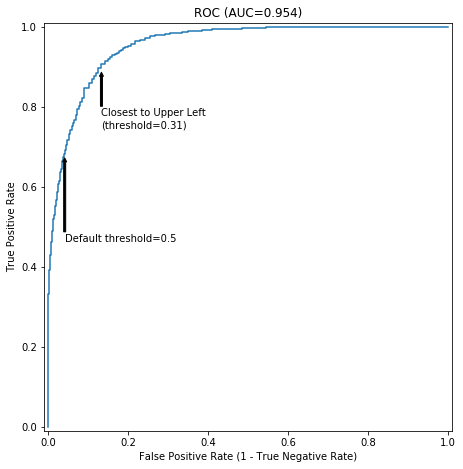

In [20]:
trainer.training_evaluator.plot_roc_curve()

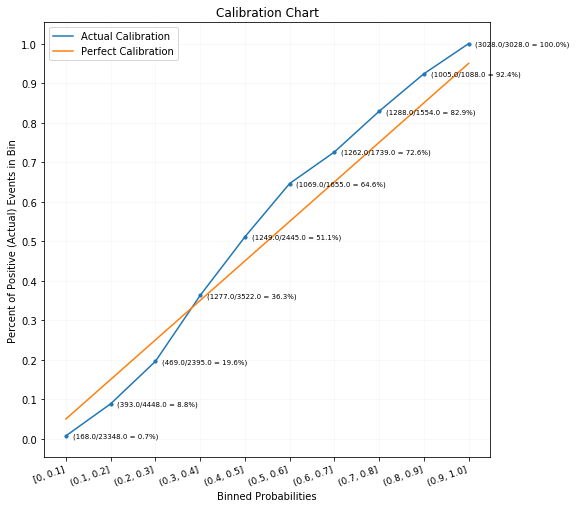

In [21]:
trainer.training_evaluator.plot_calibration()

In [22]:
csv_file = '../test_census.csv'
test_dataset = pd.read_csv(csv_file)
test_dataset.shape

(45222, 14)

In [23]:
test_dataset.head(100)

,Unnamed: 0,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0,21.0,Private,10th,6.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
1,1,49.0,Private,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,United-States
2,2,44.0,Self-emp-not-inc,Assoc-acdm,12.0,Married-civ-spouse,Other-service,Wife,White,Female,0.0,0.0,99.0,United-States
3,3,34.0,Private,Bachelors,13.0,Married-civ-spouse,Sales,Husband,White,Male,7298.0,0.0,46.0,United-States
4,4,24.0,Private,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
5,5,52.0,Private,7th-8th,4.0,Divorced,Priv-house-serv,Own-child,Black,Female,0.0,0.0,16.0,United-States
6,6,61.0,Private,7th-8th,4.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,50.0,United-States
7,7,24.0,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
8,8,30.0,Private,HS-grad,9.0,Never-married,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,22.0,United-States
9,9,42.0,Local-gov,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States


In [24]:
indexes = test_dataset['Unnamed: 0']

predictions = trainer.predict(test_dataset.drop(columns='Unnamed: 0'))
predictions.head(10)

,<=50K,>50K
0,0.977711,0.022289
1,0.341765,0.658235
2,0.806129,0.193871
3,0.000000,1.000000
4,0.973997,0.026003
5,0.991288,0.008712
6,0.686047,0.313953
7,0.965676,0.034324
8,0.995704,0.004296
9,0.444182,0.555818


In [25]:
income_value = predictions['>50K']
new_predictions = pd.DataFrame({'id': indexes, 'income': income_value})
new_predictions.to_csv('submission_x_ExtraTrees_x.csv', index=False)

# Results

## 1)

Kaggle Public: ``

File: `submission_x_ExtraTrees.csv`

Parameters: 

```

```

Originally had Mean Resampler Results of:

```

```